# QU CBE Introduction to Python Workshop - Advanced Economic Applications

**Mohammed Ait Lahcen, Department of Finance and Economics, College of Business and Economics, Qatar University**

## Solving the Neo-Classical Growth Model with a simple projection algorithm

In this notebook, I use a simple projection algorithm to solve the discrete time neo-classical growth model. 

The code below is a Python adaptation of Matlab code by [Wouter den Haan](http://www.wouterdenhaan.com/summercourse_essentials.html) at LSE.

I start by doing some imports:

In [1]:
# Computational imports
import numpy as np
from scipy import optimize as opt
from numba import njit

# Graphics imports
import matplotlib.pyplot as plt
import seaborn as sns  # Better quality figures
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)  # Sets the size of the figures in the notebook
from matplotlib import cm # for 3d poltting
from mpl_toolkits.mplot3d.axes3d import Axes3D # for 3d poltting

### 1. Model

This is a simple standard neo-classical growth model in discrete time. It has two state variables: $k_t$, the current period stock of capital, and $z_t$, the TFP level, and two choice variables $c_t$, current period consumption, and $k_{t+1}$, the next period stock of capital. 

A solution to the model has to satisfy the following system of equilibrium equations at each period $t$:

$$
\begin{align}
c_t^{-\nu} &= \mathbb{E}_t \left[ \beta c_{t+1}^{-\nu}(\alpha z_{t+1} k_{t+1}^{\alpha-1} +1 - \delta)\right] 
\\
c_t + k_{t+1} &= z_t k_t^\alpha + (1 - \delta) k_t
\\
\ln(z_{t+1}) &= \rho \ln(z_t) + \varepsilon_{t+1}
\end{align}
$$

with $\varepsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$ and taking the initial conditions $k_1$, $z_1$ as given.

One way of tackling this problem numerically is to solve directly for the optimal policy functions 
$$
\begin{align}
c_t &= c(k_t, z_t)
\\
k_{t+1} &= k(k_t,c_t)
\end{align}
$$
mapping the state variables $k_t$ and $z_t$ to the optimal choice variables $c_t$ and $k_{t+1}$. Of course, the functional forms of these policy functions are unknown.

Notice that by solving for $c_t$ we can recover $k_{t+1}$ using the budget constraint. This allows us to simply focus on finding the consumption policy function $c(k_t, z_t)$.

### 2. Numerical Solution

The idea behind projection is to find a polynomial $P_n$ which provides a good approximation to the policy function
$$
c_t = c(k_t,z_t) \approx P_n(k_t,z_t;\eta_t).
$$

I start by defining consumption as a function of the state variables and the polynomial coefficients. We choose a polynomial of order 2:

In [2]:
@njit
def c_poly(k,z,η):
    """
    Returns a polynomial approximation of consumption as a function of the state (k,z)
    """
    
    c_log = η[0] + η[1]*np.log(k) + η[2]*np.log(z) + η[3]*np.log(k)**2 + η[4]*np.log(z)**2 + η[5]*np.log(k)*np.log(z)
    
    return np.exp(c_log)

All what we have to do now is to solve for the polynomial coefficients $\eta_n$. For that I require that the polynomial minimizes the following error derived from the Euler equation:
$$
e(k_i,z_i;\eta_n) = - P_n(k_i,z_i;\eta_n)^{-\nu} + \mathbb{E} \left[ \beta P_n(k',z';\eta_n)^{-\nu}(\alpha z'k'^{\alpha-1} +1-\delta )\right]
$$

Replacing $k'$ and $z'$ in the Euler error above by their model expressions we get:
$$
e(k_i,z_i;\eta_n) = - P_n(k_i,z_i;\eta_n)^{-\nu} + \mathbb{E} \left[ \beta P_n(z_i k_i^\alpha + (1-\delta)k_i - P_n(k_i,z_i;\eta_n),e^{\rho\ln{z_i} + \varepsilon'};\eta_n)^{-\nu} \alpha e^{\rho\ln{z_i} + \varepsilon'}(z_i k_i^\alpha + (1-\delta)k_i - P_n(k_i,z_i;\eta_n))^{\alpha-1} \right]
$$

In order to compute the expectation term, we use numerical integration and in particular the [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature). We simply choose the number of nodes and then use the Numpy function `hermgauss` to generate the nodes and weights as follows:

In [3]:
n_q = 5  # Number of nodes and weights for the Gauss-Hermite quadrature

# Use the hermgauss function to get the nodes and the weights for the Gauss-Hermite quadrature
gh_quad = np.polynomial.hermite.hermgauss(n_q)

We turn next to writing the error function:

In [4]:
@njit
def euler_err(η,quad):
    """
    Returns the sum of squared Euler errors at all grid points
    
    """
    
    q_nodes, q_weights = quad
    
    ssr      =  0  # Initialize the sum of squared errors
    
    for i_k in range(len(k_grid)):  # Iterate over k and z grids
        
        for i_z in range(len(z_grid)):
            
            k       = k_grid[i_k]
            z       = z_grid[i_z]
            c       = c_poly(k,z,η)
            k_prime = z * k**α + (1-δ) * k - c;
            
            # Calculating the expectation over the GH nodes for every (k,z) weighted by the GH weights
            # We use the Gauss-Hermite formula with a change of variable
            
            E  = 0
            
            for i_q in range(len(q_nodes)):
                
                e_prime = np.sqrt(2) * σ * q_nodes[i_q]         # The errors are normally distributed with mean 0 and std σ
                z_prime = np.exp(ρ * np.log(z) + e_prime)
                c_prime = c_poly(k_prime,z_prime,η)
                
                E += q_weights[i_q] * β * c_prime**(-γ) * (α * z_prime * k_prime**(α-1) + (1-δ))            
                
            E = E / np.sqrt(np.pi)      
            ssr += (E - c**(-γ))**2

    return ssr

With the the approximation and integration steps all set up, we can solve this problem numerically.

First, we set values for the model's parameters:

In [5]:
β = 0.99
α = 0.33
δ = 0.025
γ = 4
ρ = 0.95
σ = 0.1

The steady state capital level is:
$$
k_{ss} = \left(\frac{\beta \alpha}{1-\beta(1-\delta)}\right)^{\frac{1}{1-\alpha}}
$$

In [6]:
# Calculate the steady state level of capital
k_ss = (β * α/(1-β*(1-δ)))**(1/(1-α))

Next, we set up grids for the two state variables: $k$ and $z$. The grid for capital will be centered around $k_{SS}$ and the grid for $z_t$ will be centered around its unconditional mean:

In [7]:
# Setting up the capital grid
k_low    =  0.5 * k_ss
k_high   =  1.5 * k_ss
n_k =  10
k_grid = np.linspace(k_low,k_high,n_k)

# Setting up the productivity grid (3 std)
z_low    = -3 * np.sqrt(σ**2/(1-ρ**2))
z_high   =  3 * np.sqrt(σ**2/(1-ρ**2))
n_z =  10 
z_grid  = np.exp(np.linspace(z_low,z_high,n_z))

Now that we have everything in place, we can pass the error function to a minimization routine in order to solve for the coefficients that minimize the squared sum of Euler errors:

In [8]:
# Set initial values for the coefficients
η_init = np.zeros((1, 6))

# Find solution by minimizing the errors on the grid
η_opt = opt.minimize(euler_err,η_init, args = (gh_quad,) ,method='Nelder-Mead',options={'disp':True,'maxiter':100000,'xtol': 1e-10,'ftol': 1e-10}).x
print(η_opt)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1688
         Function evaluations: 2639
[-0.25743874  0.26136128  0.70784038  0.0127294   0.04221252 -0.1024345 ]


Next, we plot the optimal consumption choice $c$ as a function of $k$ and $z$. Notice that since we solved for the approximating polynomial coefficients, we can use a finer grid for plotting:

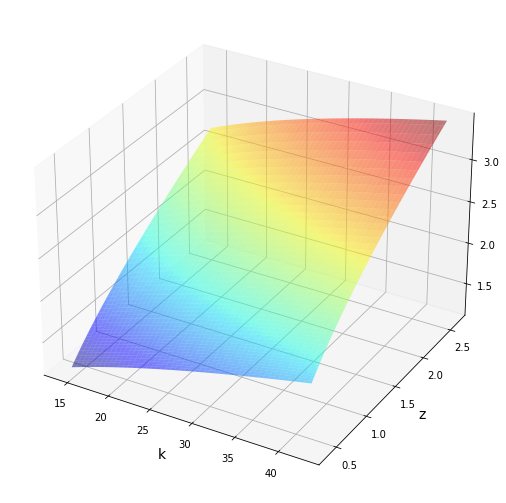

In [9]:
k_grid_fine = np.linspace(k_low,k_high,100)
z_grid_fine = np.exp(np.linspace(z_low,z_high,100))

# Generate meshgrid coordinates for 3d plot
kg, zg = np.meshgrid(k_grid_fine, z_grid_fine)

# Plot policy function approximation
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kg,
                zg,
                c_poly(kg,zg,η_opt),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set_xlabel('k', fontsize=14)
ax.set_ylabel('z', fontsize=14)
plt.show()